In [1]:
# Import libraries 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import datetime 
import time 

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in HCF variables for CAM6+CLM5 

In [2]:
# Read in netCDF file containing all the HCF variables previously computed... 
filePath      = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM5-islarun_1980-1982.nc'
HCFvars_CLM5  = xr.open_dataset(filePath, decode_times=True)
times_CLM5    = pd.DatetimeIndex(HCFvars_CLM5['time'].values)

In [3]:
# Limit above to JJA 
iJJA_CLM5        = np.where( (times_CLM5.month>=6) & (times_CLM5.month<=8) )[0]
HCFvars_CAM6_JJA = HCFvars_CLM5.isel(time=iJJA_CLM5)


In [4]:
# Read in other years (1983-89) and tack onto DS 
hcfDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
years  = np.arange(1983,1990,1).astype(str) 

fileStart = 'HCFvariables-CAM6CLM5_'

for iYear in range(len(years)):
    fileName = hcfDir+fileStart+years[iYear]+'.nc'
    
    hcf_ds = xr.open_dataset(fileName, decode_times=True)
    
    HCFvars_CAM6_JJA = xr.concat([HCFvars_CAM6_JJA,hcf_ds], dim='time')
    print('Done with year %s' % years[iYear])


Done with year 1983
Done with year 1984
Done with year 1985
Done with year 1986
Done with year 1987
Done with year 1988
Done with year 1989


## Read in HCF variables for CAM5+CLM5 

In [7]:
# Read in other years (1983-89) and tack onto DS 
hcfDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
years  = np.arange(1980,1990,1).astype(str) 

fileStart = 'HCFvariables-CAM5CLM5_'

for iYear in range(len(years)):
    fileName = hcfDir+fileStart+years[iYear]+'.nc'
    
    hcf_ds = xr.open_dataset(fileName, decode_times=True)
    
    if iYear==0:
        HCFvars_CAM5_JJA = hcf_ds 
    else:
        HCFvars_CAM5_JJA = xr.concat([HCFvars_CAM5_JJA,hcf_ds], dim='time')
        
    print('Done with year %s' % years[iYear])


Done with year 1980
Done with year 1981
Done with year 1982
Done with year 1983
Done with year 1984
Done with year 1985
Done with year 1986
Done with year 1987
Done with year 1988
Done with year 1989


In [8]:
HCFvars_CAM5_JJA.time

<xarray.DataArray 'time' (time: 920)>
array(['1980-06-01T12:00:00.000000000', '1980-06-02T12:00:00.000000000',
       '1980-06-03T12:00:00.000000000', ..., '1989-08-29T12:00:00.000000000',
       '1989-08-30T12:00:00.000000000', '1989-08-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-06-01T12:00:00 ... 1989-08-31T12:00:00

## Plot some maps 

In [9]:
# Pull out dimensions
lat  = HCFvars_CAM5_JJA.lat.values
lon  = HCFvars_CAM5_JJA.lon.values
time = HCFvars_CAM5_JJA.time.values


In [10]:
# Pull out a few key variables 
thetaBM_CAM5  = HCFvars_CAM5_JJA.TBM.values
thetaBM_CAM6  = HCFvars_CAM6_JJA.TBM.values

thetaAdv_CAM5 = HCFvars_CAM5_JJA.TRAN_T.values
thetaAdv_CAM6 = HCFvars_CAM6_JJA.TRAN_T.values


In [11]:
# ----- Also apply a land mask (based on same resolution in another sim) -----

# Read in single history file to get lat/lon and masks 
testName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
latGlobal = testDF.lat
lonGlobal = testDF.lon

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

# Pick out CONUS 
ilatConus = np.where((latGlobal>=np.min(lat)) & (latGlobal<=np.max(lat)))[0]
ilonConus = np.where((lonGlobal>=np.min(lon)) & (lonGlobal<=np.max(lon)))[0]
landMask = landMask[ilatConus,:]
landMask = landMask[:,ilonConus]
np.shape(landMask)

# Now apply that land mask to above calculated variables 
thetaBM_CAM5  = thetaBM_CAM5*landMask
thetaBM_CAM6  = thetaBM_CAM6*landMask
thetaAdv_CAM5 = thetaAdv_CAM5*landMask
thetaAdv_CAM6 = thetaAdv_CAM6*landMask


### Plot: Summer-mean theta_BM (buoyant mixing potential temperature) 

In [12]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap




In [13]:
### Create a list of RGB tuples
colorsList_theta = [(  9,0,146), 
                     (20,2,228),
                     (20,49,245),
                     (71,159,247),
                     (111,240,252),
                     (117,252,172),
                     (124,252,76),
                     (253,241,80),
                     (241,160,57),
                     (234,58,36),
                     (233,51,35),
                     (150,28,19)] # This example uses the 8-bit RGB

my_cmap_Theta = make_cmap(colorsList_theta, bit=True)


In [15]:
bounds = np.arange(297,334,3)
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


<ipython-input-17-d9e55024aa4a>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CAM5, axis=0),


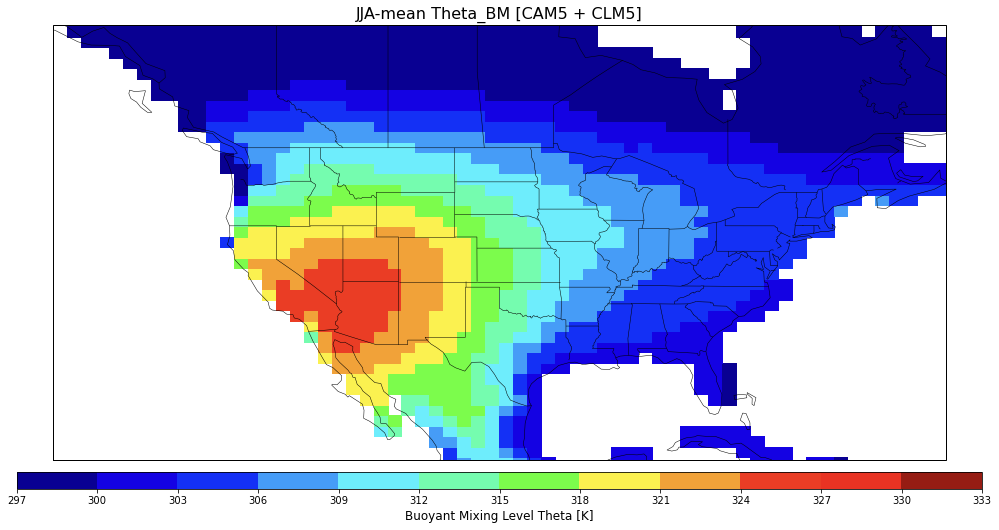

In [17]:
# Plot mean Theta_BM 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CAM5, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_BM [CAM5 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)
cbar.set_label('Buoyant Mixing Level Theta [K]',fontsize=12)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')





<ipython-input-18-bb5573f30253>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CAM6, axis=0),


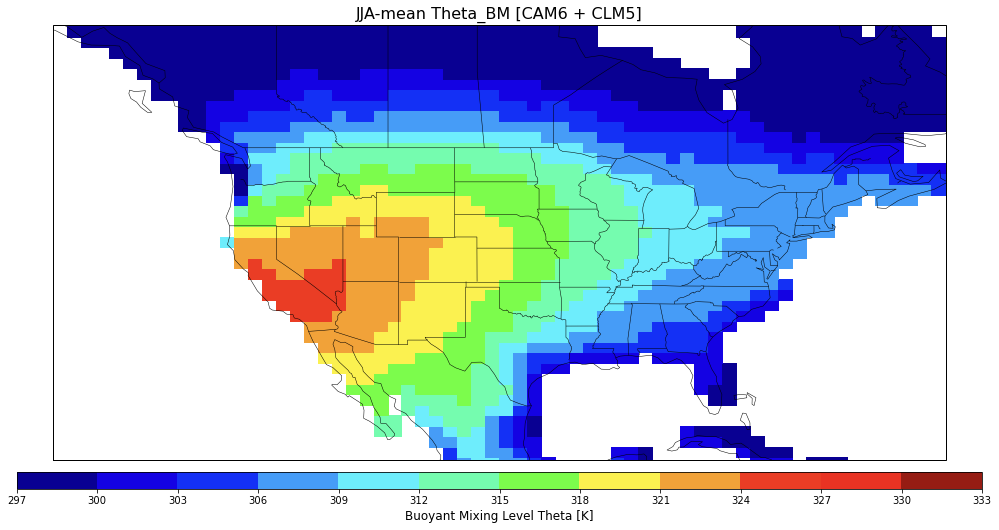

In [18]:
# Plot mean TBM 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CAM6, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_BM [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)
cbar.set_label('Buoyant Mixing Level Theta [K]',fontsize=12)



# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')




<ipython-input-19-469b2eeeba03>:15: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(diff_thetaBM, axis=0)*landMask,


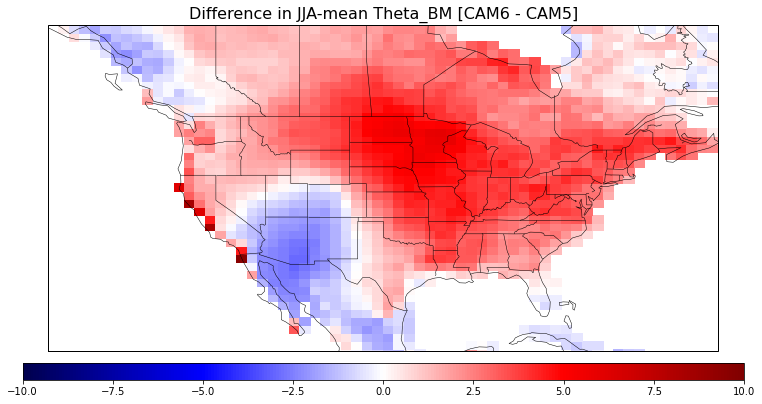

In [19]:
# Plot difference in modeled Theta_BM (CLM5 - CLM4.5)

diff_thetaBM = thetaBM_CAM6 - thetaBM_CAM5

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(diff_thetaBM, axis=0)*landMask,
                             vmin=-10,vmax=10,
                             cmap='seismic')

# Additional options 
ax1.set_title('Difference in JJA-mean Theta_BM [CAM6 - CAM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
